In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'recipe-for-rating-predict-food-ratings-using-ml:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F67079%2F7452256%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T062955Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0336582ece8b73e16099bac8fc9266829f632f168874ff9bb163fafc5b62e948600971def81b27f53096007416ba1013ebb1370ea67c249e96bb1ab4717dcf72a960d53471e5332cea95ef7d29cb84991e4073343a3afc5740fe3b5d913bf249327811d170dac1c427642237d1b9aa1f391ad9ec3cfc89d9baff12e12b239d201f8ad735cb2ec178bf4e409a9e809f364b438db4f4ee873ca886f7002feb0bee963e14eb07665dfebc36316588f5d46530a4f3e80b70a56b73317724bdb1e54a547db1c7d05c7f099afd95b8d536765767a6ee3fa3f1be62cf48e20e699af5397f2fdcb5cb65cc071e67f7c7fa0e9b60a3ada9efa81b38d9bc869752e477077e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


In [ ]:
# Importing all required libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
# Reading Train and Test files

train = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
test = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")

#### About the Training Data

In [ ]:
train.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [ ]:
# Shape of Training Data
train.shape

(13636, 15)

In [ ]:
# Info regarding training data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [ ]:
# descriptive statistics
train.describe()

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13636.000000,13636.000000,13636.000000,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,121.085289,38.624377,21785.990833,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897
std,116.995633,29.672351,23883.189918,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
75%,148.000000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
max,724.000000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.000000


#### Data Cleaning

In [ ]:
# Columns in training dataset
train.columns.tolist()

['ID',
 'RecipeNumber',
 'RecipeCode',
 'RecipeName',
 'CommentID',
 'UserID',
 'UserName',
 'UserReputation',
 'CreationTimestamp',
 'ReplyCount',
 'ThumbsUpCount',
 'ThumbsDownCount',
 'Rating',
 'BestScore',
 'Recipe_Review']

In [ ]:
# Checking for null values
train.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

In [ ]:
# Checking for NaN values
train.isna().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

In [ ]:
# Checking unique values in each of the columns of the training dataset

# Checking for invalid inputs for the following:
# UserReputation: Non-negative numerical values.
# ReplyCount, ThumbsUpCount, ThumbsDownCount: Non-negative integer values.
# Rating: Numerical values within a specific range [0, 5].
# BestScore: Non-negative numerical values.

columns = ['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore']

for column in columns:
    unique_values = train[column].unique()
    print(f"Unique values for column '{column}': {unique_values}")

Unique values for column 'UserReputation': [ 20   1  10  80  30   0  60  90 160  40 510 100  50 140  70 220 110 130
 150 300]
Unique values for column 'ReplyCount': [0 1 2 3]
Unique values for column 'ThumbsUpCount': [ 0  1  3  2 23  5 36  4  8 31 10 20  7  6 12 18  9 22 13 11 15 32 26 16
 76 19 44 35 45 29 55 42 14 27 41 37 30 21 24 17 33 40 28 25 73 39 57 80
 69 43 47 79 46 50 68 34 48]
Unique values for column 'ThumbsDownCount': [  0   1  10  29   6   3   5   9   2   4  17   8  13  11   7  12  15  19
  78  26  21  41  16  40  62  31  55  14  24  20  71  25  49  37  39  18
  65  32 126  63  46  30  23 104  42  70  22  87  27  61  38]
Unique values for column 'Rating': [5 3 4 0 2 1]
Unique values for column 'BestScore': [100 193 136 253 485 556 530 859 329 354 120 259 840 381 720 623 323 522
 297 538 799 167 278 240 635 400 777 127 414 142 523 390 211 235 516 109
 203 854 767 404 348 484 303 779 588 830 848 770 467 143 757 810 415 819
 261 319 616 440 153 695 163 561 513 833 599 395 7

In [ ]:
# Replace NaN values in 'Recipe_Review' column with 'NIL'
train['Recipe_Review'].fillna('NIL', inplace=True)

/tmp/ipykernel_34/300075851.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Recipe_Review'].fillna('NIL', inplace=True)


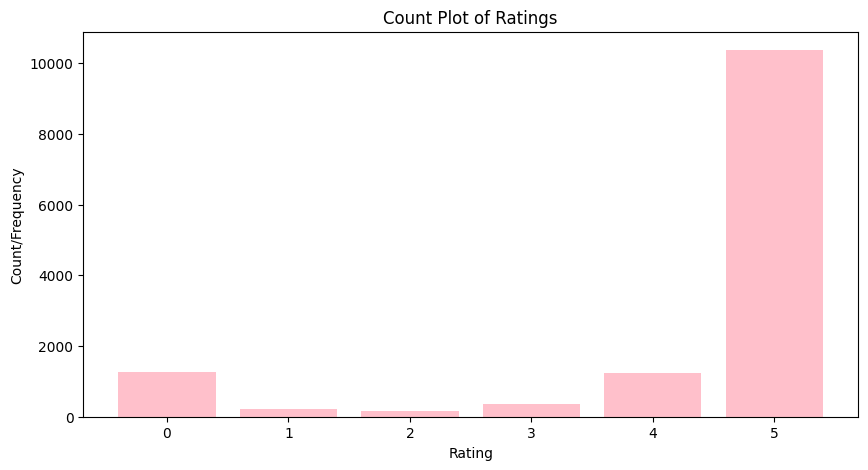

In [ ]:
# Assuming 'df' is your DataFrame
ratings = train['Rating'].value_counts()

# Using Matplotlib to create a count plot
plt.figure(figsize=(10, 5))
plt.bar(ratings.index, ratings, color='pink')
plt.title('Count Plot of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count/Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

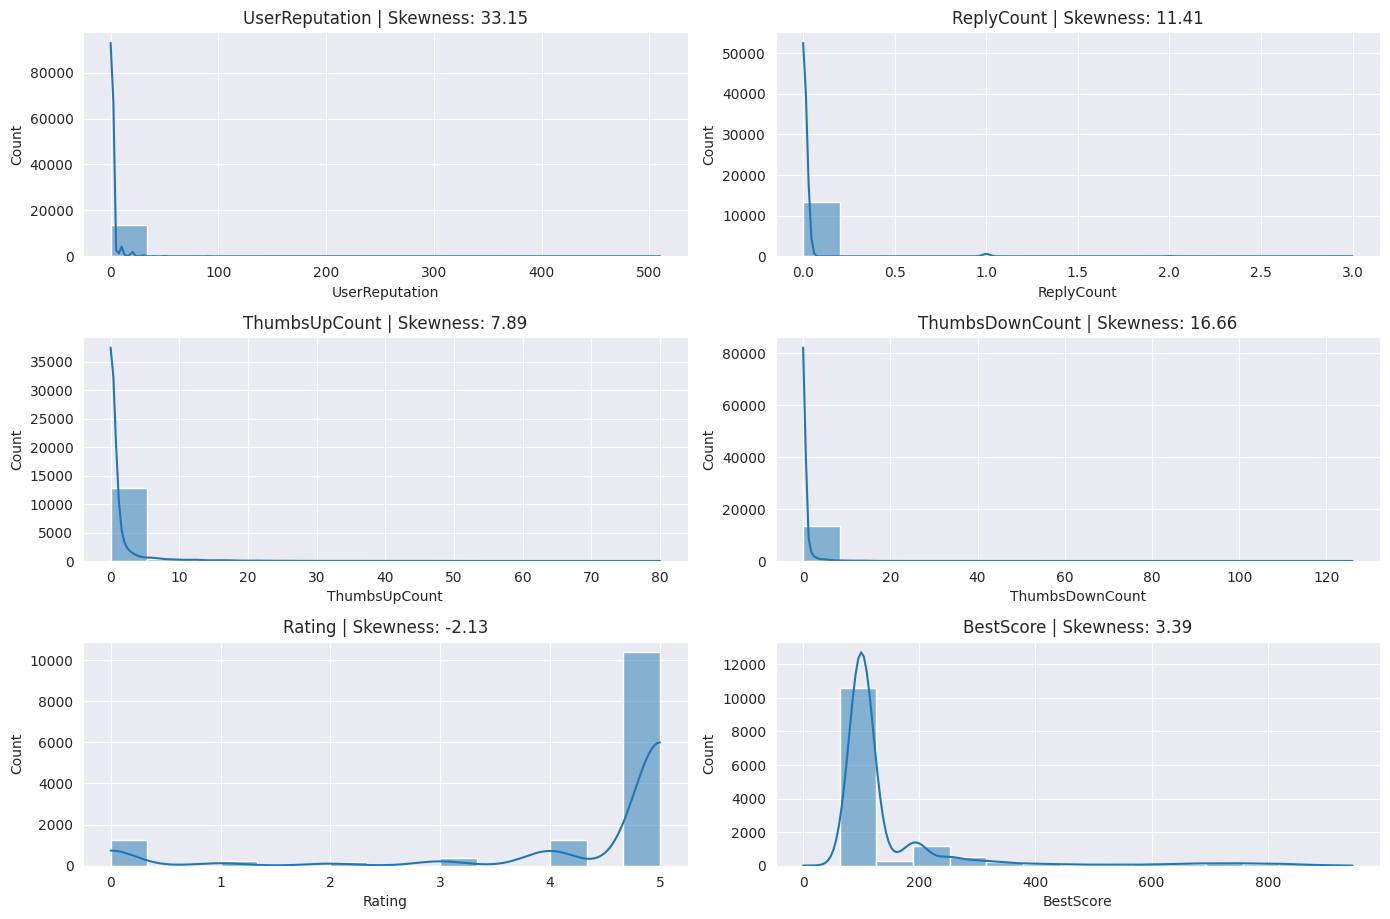

In [ ]:
# Set Seaborn style
sns.set_style("darkgrid")

# All numerical columns
numerical_columns =['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore']

# Plotting distribution of each numerical feature
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(train[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(train[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

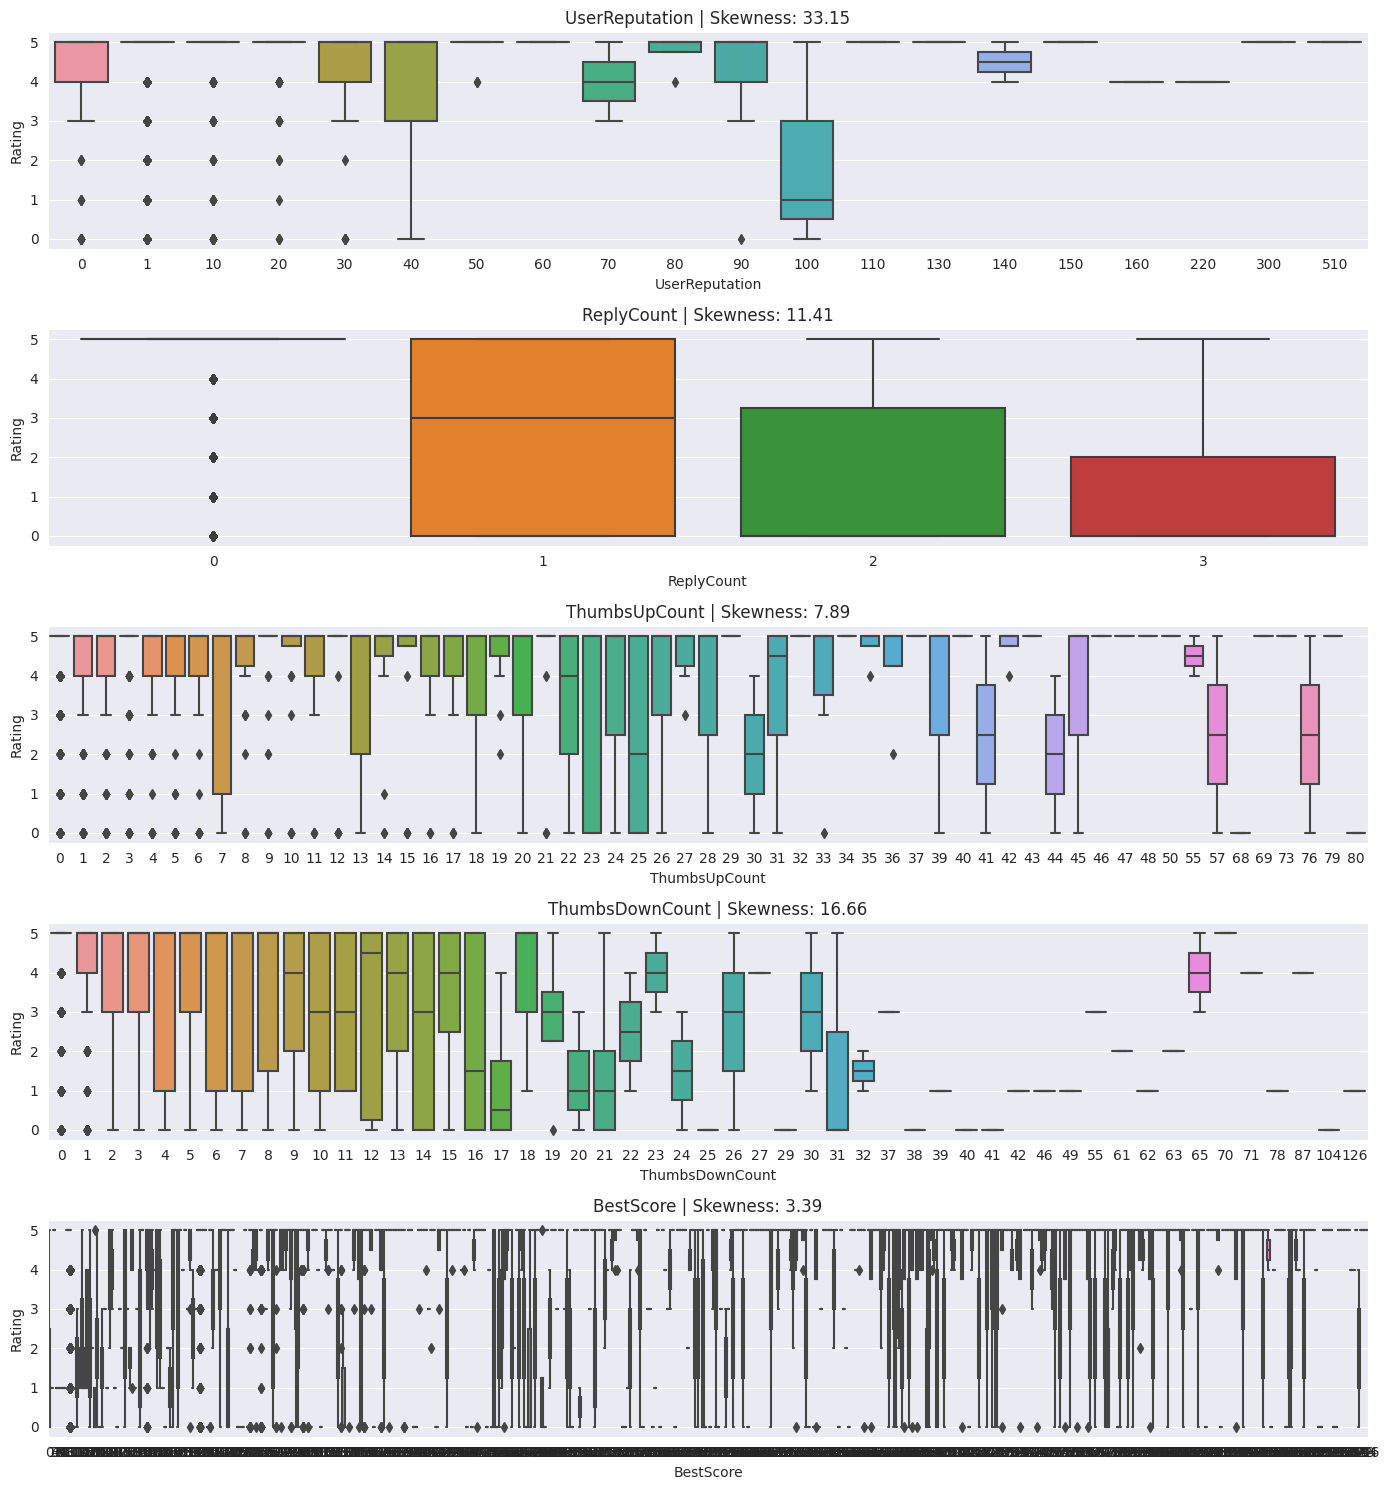

In [ ]:
# Box Plot : Numerical Features vs Ratings

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
numerical_columns = ['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, idx)
    sns.boxplot(x=train[feature], y=train['Rating'])
    plt.title(f"{feature} | Skewness: {round(train[feature].skew(), 2)}")
plt.tight_layout()
plt.show()

#### Checking for Multicolinearity and Importance of Variables

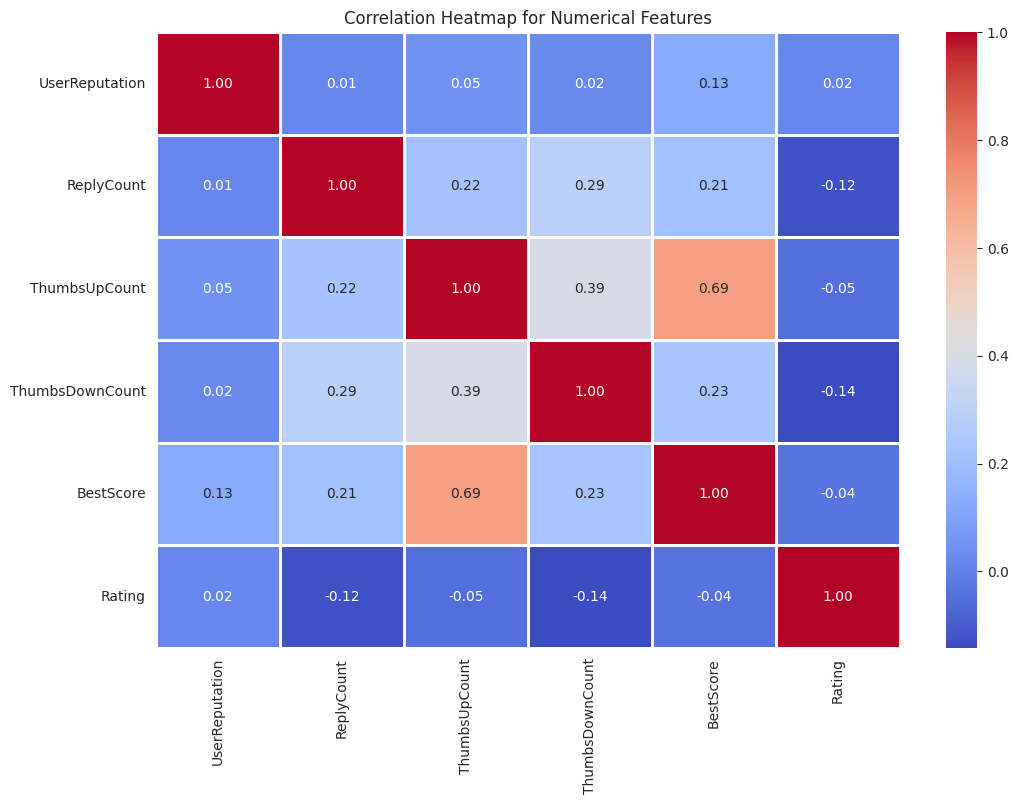

In [ ]:
# Correlation Heat Map

numerical_data = train[['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore','Rating']]
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=2)
plt.title('Correlation Heatmap for Numerical Features')
plt.show()


In [ ]:
numerical_data = train[['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore']]
X_with_const = add_constant(numerical_data)
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Print VIF for each feature
print(vif_data)

           feature        VIF
0            const  10.761504
1   UserReputation   1.019257
2       ReplyCount   1.130503
3    ThumbsUpCount   2.176559
4  ThumbsDownCount   1.274163
5           Rating   1.029202
6        BestScore   1.986289


UserReputation: The VIF value of approximately 1.02 indicating low multicollinearity

ReplyCount: Similarly, with a VIF of around 1.13, indicating low multicollinearity

ThumbsUpCount: This feature has a VIF of about 2.18, indicating moderate multicollinearity.

ThumbsDownCount: The VIF value of approximately 1.27 indicating low multicollinearity.

Rating: Similarly, with a VIF of around 1.02, indicating low multicollinearity

BestScore: The VIF value of approximately 1.98 indicating low multicollinearity.


In [ ]:
from scipy.stats import chi2_contingency

X=numerical_data
# Perform Chi-square test for each categorical feature
chi2_results = {}
for column in X.columns:
    if X[column].dtype == 'int64':
        contingency_table = pd.crosstab(X[column], train['Rating'])
        chi2_result = chi2_contingency(contingency_table)
        chi2_results[column] = chi2_result

# Print Chi-square test results
for column, result in chi2_results.items():
    print(f"Feature: {column}, p-value: {result[1]}")

Feature: UserReputation, p-value: 0.041126549940447066
Feature: ReplyCount, p-value: 8.370622405816741e-51
Feature: ThumbsUpCount, p-value: 0.0027853743505592624
Feature: ThumbsDownCount, p-value: 0.0
Feature: Rating, p-value: 0.0
Feature: BestScore, p-value: 2.738423604626112e-216


UserReputation: The p-value is approximately 0.0411, which shows there is a statistically significant association between UserReputation and Rating.

ReplyCount: The p-value is very small (close to 0), indicating a very strong statistical association between ReplyCount and Rating.

ThumbsUpCount: The p-value is approximately 0.0028, indicating a statistically significant association between ThumbsUpCount and Rating.

ThumbsDownCount: The p-value is 0, which suggests a highly significant association between ThumbsDownCount and Rating.

BestScore: The p-value is extremely small (close to 0), indicating a very strong statistical association between BestScore and Rating.

#### The most important features and the best set of them are UserReputation,ReplyCount, ThumbsDownCount,BestScore

# **Modelling**

## Using Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
X_train = train.drop(columns=['Rating'])
y_train = train['Rating']

In [ ]:
dc = DummyClassifier(strategy="most_frequent")
dc.fit(X_train,y_train)
y_pred = dc.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7605602816075095
Precision: 0.12676004693458492
Recall: 0.16666666666666666


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


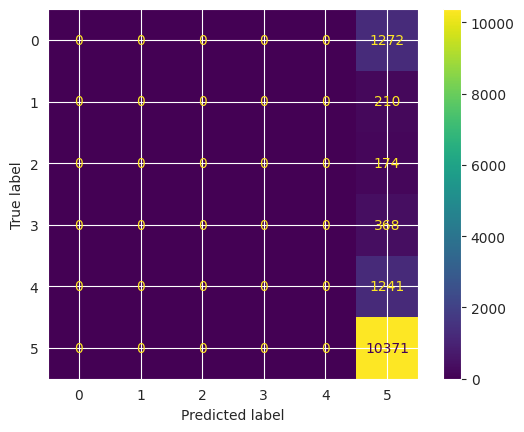

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

##### Accuracy obtained on the training dataset through the use of dummy classifier is 76.05602%

## Using K-Nearest Neighours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
X_train=train[[ 'UserReputation','ReplyCount', 'ThumbsDownCount','BestScore']]

In [ ]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.5593908651359836
Recall: 0.23108452856951245
Accuracy: 0.7653270753886771


##### Accuracy obtained on the training dataset through the use of k-nearest neighbours classifier algorithm is 76.53270%

### Using Decision Tree

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

In [ ]:
dtc=DecisionTreeClassifier(random_state=0)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
y_pred = dtc.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.8265621778950786
Recall: 0.30356880577826445
Accuracy: 0.78813435024934


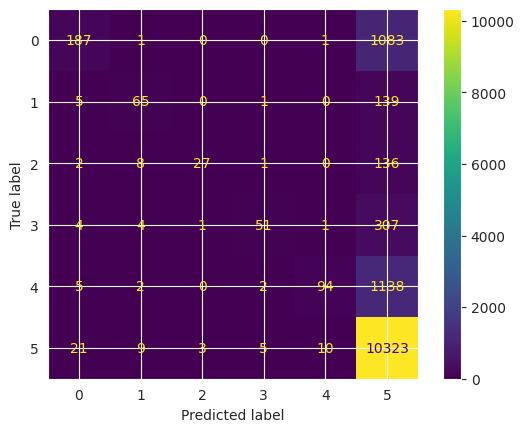

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

##### Accuracy obtained on the training dataset through the use of decision trees classifier algorithm is 78.81343%

### Now, I use Grid Search CV to find the best parameters suiting the model to obtain the heighest percentage of training accuracy

#### 1. With Feature Scaling

In [ ]:
pipeline = Pipeline([
    ('feature_scaling',StandardScaler()),
    ('dt_clf', DecisionTreeClassifier(random_state=1))
])

In [ ]:
dt_clf_search = GridSearchCV(pipeline, param_grid={'dt_clf__max_depth':[1,2,3,4,5,6,7,8,9,10],
                                                   'dt_clf__min_samples_split': [2,4,6,8,10],
                                                   "dt_clf__criterion":['gini','entropy'],
                                                   "dt_clf__min_samples_split":range(1,10),
                                                   "dt_clf__min_samples_leaf":range(1,5)},
                             scoring = 'f1_macro',n_jobs=2, cv=5, return_train_score=True)

# Cross validation using 5 sets

In [ ]:
dt_clf_search.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/opt/conda/lib/python3.10/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_clf',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=2,
             param_grid={'dt_clf__criterion': ['gini', 'entropy'],
                         'dt_clf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'dt_clf__min_samples_leaf': range(1, 5),
                         'dt_clf__min_samples_split': range(1, 10)},
             return_train_score=True, scoring='f1_macro')

In [ ]:
dt_clf_search.best_params_

{'dt_clf__criterion': 'entropy',
 'dt_clf__max_depth': 10,
 'dt_clf__min_samples_leaf': 4,
 'dt_clf__min_samples_split': 9}

##### The best set of paramters for the model are:
1. Criterion : Entropy
2. Max depth : 10
3. Minimum Leaf Samples : 4
4. Minimum Split Samples : 9

In [ ]:
y_pred = dt_clf_search.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy: ", accuracy)

Precision: 0.5445173624043166
Recall: 0.2310193969274136
Accuracy:  0.7681138163684365


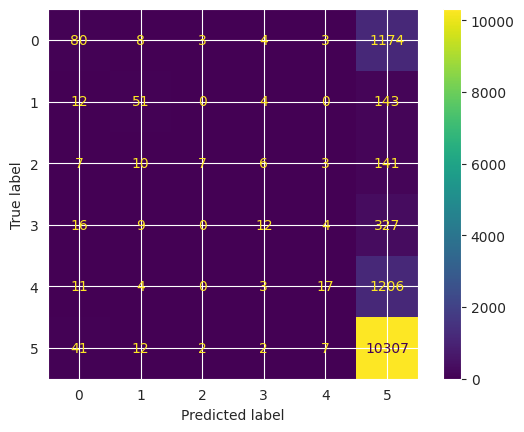

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

##### Accuracy obtained on the training dataset through the use of decision trees classifier algorithm and Grid Search CV with scaling of variables using StandardScaler is 76.81138%

##### Clearly, decision tree with default parameter settings provide better training results

#### 2. Without Feature Scaling

In [ ]:
pipeline = Pipeline([
    ('dt_clf', DecisionTreeClassifier(random_state=1))
])

In [ ]:
dt_clf_search = GridSearchCV(pipeline, param_grid={'dt_clf__max_depth':[1,2,3,4,5,6,7,8,9,10],
                                                   'dt_clf__min_samples_split': [2,4,6,8,10],
                                                   "dt_clf__criterion":['gini','entropy'],
                                                   "dt_clf__min_samples_split":range(1,10),
                                                   "dt_clf__min_samples_leaf":range(1,5)},
                             scoring = 'f1_macro',n_jobs=2, cv=5, return_train_score=True)

# Cross validation using 5 sets

In [ ]:
dt_clf_search.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
400 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/opt/conda/lib/python3.10/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dt_clf',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=2,
             param_grid={'dt_clf__criterion': ['gini', 'entropy'],
                         'dt_clf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'dt_clf__min_samples_leaf': range(1, 5),
                         'dt_clf__min_samples_split': range(1, 10)},
             return_train_score=True, scoring='f1_macro')

In [ ]:
dt_clf_search.best_params_

{'dt_clf__criterion': 'entropy',
 'dt_clf__max_depth': 10,
 'dt_clf__min_samples_leaf': 4,
 'dt_clf__min_samples_split': 9}

##### The best set of paramters for the model are:
1. Criterion : Entropy
2. Max depth : 10
3. Minimum Leaf Samples : 4
4. Minimum Split Samples : 9

In [ ]:
y_pred = dt_clf_search.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy: ", accuracy)

Precision: 0.5445173624043166
Recall: 0.2310193969274136
Accuracy:  0.7681138163684365


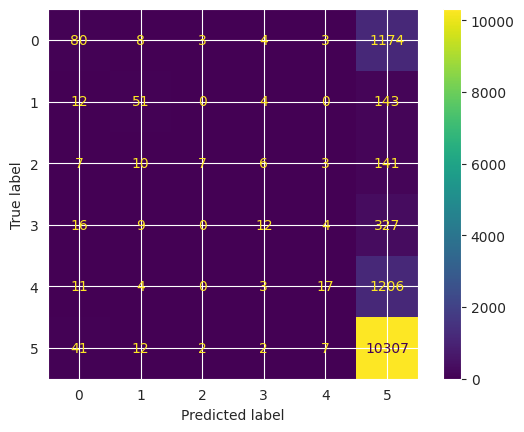

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

##### Accuracy obtained on the training dataset through the use of decision trees classifier algorithm and Grid Search CV without scaling of variables is 76.81138%

##### Clearly, the accuracy score did not change due to scaling, and hence Scaling does not affect the model.

## Using SGD Classifier

#### 1. SGD with default parameters

In [ ]:
from sklearn.linear_model import SGDClassifier

SGDestimator = SGDClassifier(random_state=0)
pipe_sgd = Pipeline([
    ('minmaxscaler', MinMaxScaler()),
    ('SGD', SGDestimator)
])
pipe_sgd.fit(X_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('SGD', SGDClassifier(random_state=0))])

In [ ]:
y_pred = pipe_sgd.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy: ", accuracy)

Precision: 0.3639324882752711
Recall: 0.16961070155015154
Accuracy:  0.761513640363743


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


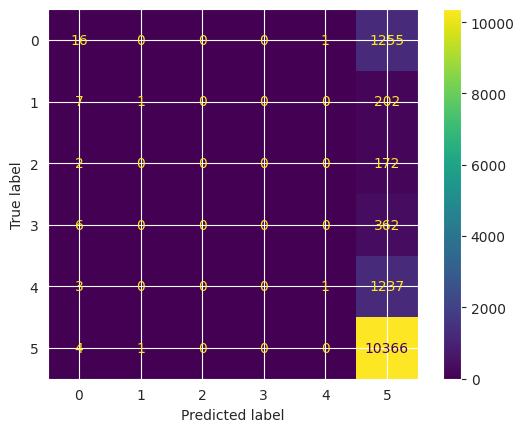

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

##### Accuracy obtained on the training dataset through the use of SGD Classifier with deafult parameters is 76.15136%

#### 2. SGD with certain parameters

In [ ]:
SGDestimator = SGDClassifier(loss='log',
                         penalty='l2',
                         max_iter=1,
                         warm_start=True,
                         eta0=0.01,
                         alpha=0,
                         learning_rate='constant',
                         random_state=0)
pipe_sgd = Pipeline([
    ('minmaxscaler', MinMaxScaler()),
    ('SGD', SGDestimator)
])

In [ ]:
pipe_sgd.fit(X_train,y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('SGD',
                 SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant',
                               loss='log', max_iter=1, random_state=0,
                               warm_start=True))])

In [ ]:
y_pred = pipe_sgd.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy: ", accuracy)

Precision: 0.12676004693458492
Recall: 0.16666666666666666
Accuracy:  0.7605602816075095


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


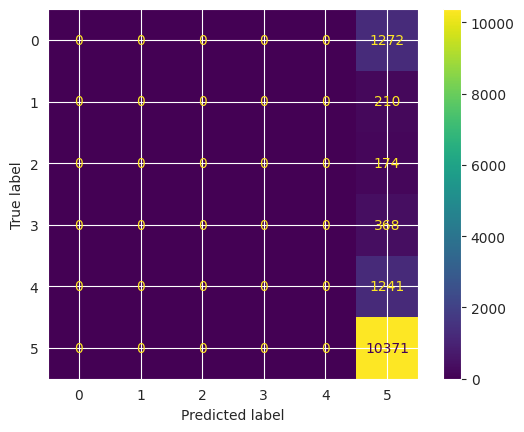

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

##### Accuracy obtained on the training dataset through the use of the above specified SGD classifier is 76.05062%

#### Using Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFC_clf = Pipeline([("classifier", RandomForestClassifier())])

RFC_clf.fit(X_train, y_train)
print("Model score/accuracy:" , RFC_clf.score(X_train, y_train))
y_pred = RFC_clf.predict(X_train)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)

Model score/accuracy: 0.78813435024934
Precision: 0.8564138458348203
Recall: 0.29591454488115526


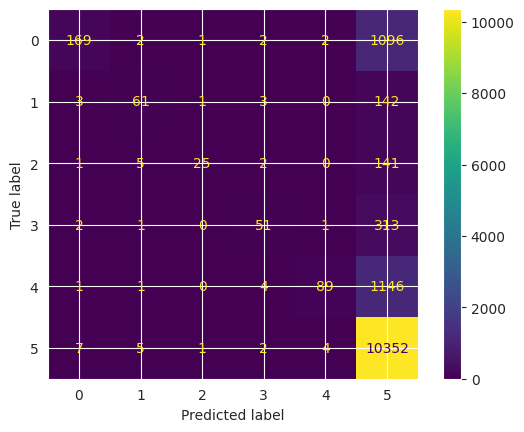

In [ ]:
y_pred=RFC_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

##### Accuracy obtained on the training dataset through the use of random forest classifier is 78.81343%

## Algorithms with a New Feature based on the **sentiment of words**

In [ ]:
x_train = train[["UserReputation", "ReplyCount", "ThumbsDownCount", "BestScore", "Recipe_Review"]]

In [ ]:
def check_positive_words(review):
    positive_words = ['delicious', 'amazing', 'tasty', '!']

    count = 0
    for word in positive_words:
        if word in str(review).lower():
            count += 1

    return count

x_train['positive_feedback'] = x_train['Recipe_Review'].apply(check_positive_words)

/tmp/ipykernel_34/337253934.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['positive_feedback'] = x_train['Recipe_Review'].apply(check_positive_words)


In [ ]:
x_train.head()

,UserReputation,ReplyCount,ThumbsDownCount,BestScore,Recipe_Review,positive_feedback
0,20,0,0,100,great recipe! I have made them just as written...,1
1,1,0,1,100,This is an easy and quick recipe that is great...,0
2,1,0,0,100,I think I was looking for something extra spec...,0
3,1,0,0,100,This is our favorite grilled chicken recipe. ...,1
4,1,0,0,100,Great basic recipe. I added 2 teaspoons Tuscan...,1


In [ ]:
x_train=x_train.drop(columns=['Recipe_Review'])

In [ ]:
clf_dtc=DecisionTreeClassifier(random_state=1)
clf_dtc.fit(x_train,y_train)

DecisionTreeClassifier(random_state=1)

In [ ]:
y_pred = clf_dtc.predict(x_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy: ", accuracy)

Precision: 0.8311390687883226
Recall: 0.3230624234256639
Accuracy:  0.7922411264300382


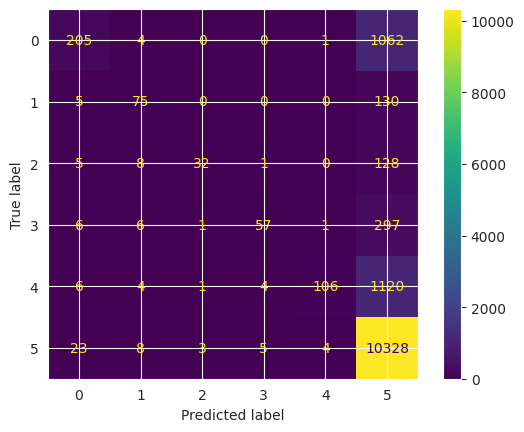

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

In [ ]:
SGDestimator_2 = SGDClassifier(random_state=0)

In [ ]:
SGDestimator_2.fit(x_train, y_train)

SGDClassifier(random_state=0)

In [ ]:
y_pred = SGDestimator_2.predict(x_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy: ", accuracy)

Precision: 0.23528985068718747
Recall: 0.20885771740832024
Accuracy:  0.4764593722499267


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


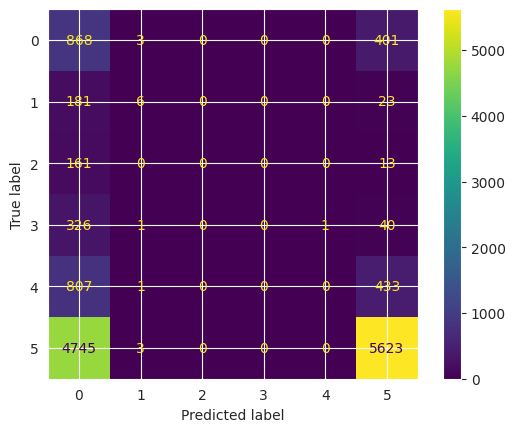

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

In [ ]:
knn_2=KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn_2.fit(x_train,y_train)

KNeighborsClassifier()

In [ ]:
y_pred=knn_2.predict(x_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy: ", accuracy)

Precision: 0.36886149337983315
Recall: 0.2728455762531809
Accuracy:  0.5942358462892344


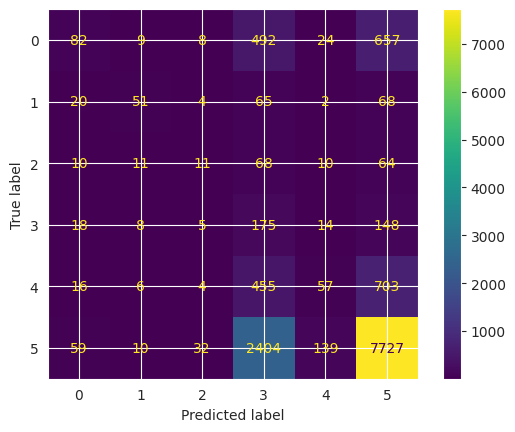

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_RFC_pipeline = Pipeline(
    steps=[ ("rfclassifier", RandomForestClassifier())]
)
param_grid={'rfclassifier__max_features': ['sqrt', 'log2'],
            'rfclassifier__max_depth' : [4,5,6,7,8,9,10],
            'rfclassifier__criterion' :['gini', 'entropy']
                     }
gd=GridSearchCV(clf_RFC_pipeline,param_grid=param_grid,cv=5)

In [ ]:
gd.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfclassifier',
                                        RandomForestClassifier())]),
             param_grid={'rfclassifier__criterion': ['gini', 'entropy'],
                         'rfclassifier__max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'rfclassifier__max_features': ['sqrt', 'log2']})

In [ ]:
print("model score:", gd.score(x_train, y_train))
y_pred=gd.predict(x_train)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)

model score: 0.7668671164564388
Precision: 0.8308849232849381
Recall: 0.21438997888474473


# Using Balanced Data

In [ ]:
undersampler = RandomUnderSampler(random_state=42)
X_sampled_train, y_sampled_train = undersampler.fit_resample(X_train, y_train)

## K-Nearest Neighbours

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn.fit(X_sampled_train, y_sampled_train)
y_pred = knn.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.21114377370778734
Recall: 0.26177112010187287
Accuracy: 0.10560281607509533


In [ ]:
dtc=DecisionTreeClassifier(random_state=0)
dtc.fit(X_sampled_train,y_sampled_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
y_pred=dtc.predict(X_train)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
accuracy = accuracy_score(y_train, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.2325672575775228
Recall: 0.30514176923463765
Accuracy: 0.6041361102962746


## SGD Classifier

In [ ]:
SGDestimator = SGDClassifier(random_state=0)
pipe_sgd = Pipeline([
    ('minmaxscaler', MinMaxScaler()),
    ('SGD', SGDestimator)
])
pipe_sgd.fit(X_sampled_train,y_sampled_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('SGD', SGDClassifier(random_state=0))])

In [ ]:
y_pred = pipe_sgd.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy: ", accuracy)

Precision: 0.2051610361701801
Recall: 0.21992558672700116
Accuracy:  0.1001760046934585


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Clearly, balancing the data is not providing best good results. It is poorer compared to the models which were trained on unbalanced data.

## Using Bagging Classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train['Recipe_Review'])
X = vectorizer.transform(train['Recipe_Review'])

In [ ]:
additional_features = train[[ 'UserReputation','ReplyCount', 'ThumbsDownCount','BestScore']]
X_with_features = np.hstack((X.toarray(), additional_features.values))
X_train, y_train = X_with_features, train['Rating']

In [ ]:
base_classifier = RandomForestClassifier()
bagging_classifier = BaggingClassifier(base_estimator=base_classifier, n_estimators=3, random_state=42)
bagging_classifier.fit(X_train, y_train)
predictions = bagging_classifier.predict(X_train)
accuracy = accuracy_score(y_train, predictions)
print("Accuracy:", accuracy)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.910164271047228


The accuracy is 0.910

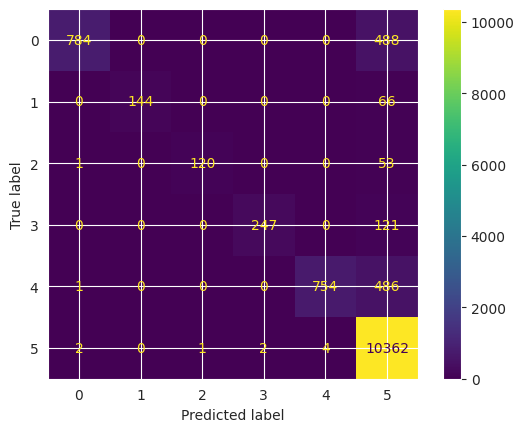

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,predictions,values_format='.5g')

## Random Forest Classifier

In [ ]:
RFC_clf = Pipeline([("classifier", RandomForestClassifier())])
X_train = train[[ 'UserReputation','ReplyCount', 'ThumbsDownCount','BestScore']]
RFC_clf.fit(X_train, y_train)
print("model score/accuracy:" , RFC_clf.score(X_train, y_train))
y_pred = RFC_clf.predict(X_train)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)

model score/accuracy: 0.78813435024934
Precision: 0.848231550427395
Recall: 0.30023600164114983


## Using Count Vectorization and Random Forest

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.datasets import make_classification, load_iris
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss, precision_score, recall_score, classification_report, precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train['Recipe_Review'])
X = vectorizer.transform(train['Recipe_Review'])

In [ ]:
print("Shape of X:", X.shape)
print("Sample of X:")
print(X[:10])
print("Sample of X (dense format):")
print(X[:10].toarray())

Shape of X: (13636, 10481)
Sample of X:
  (0, 459)	1
  (0, 651)	3
  (0, 792)	2
  (0, 2368)	1
  (0, 2494)	1
  (0, 2706)	1
  (0, 2835)	1
  (0, 3727)	1
  (0, 4134)	1
  (0, 4237)	1
  (0, 4413)	3
  (0, 5102)	1
  (0, 5593)	2
  (0, 6003)	2
  (0, 6231)	1
  (0, 6237)	1
  (0, 6298)	1
  (0, 6872)	1
  (0, 7481)	1
  (0, 7760)	1
  (0, 8478)	1
  (0, 8567)	1
  (0, 8779)	1
  (0, 8818)	1
  (0, 9279)	1
  :	:
  (7, 10029)	1
  (7, 10184)	1
  (7, 10275)	1
  (8, 515)	1
  (8, 651)	1
  (8, 1020)	1
  (8, 2679)	1
  (8, 2893)	1
  (8, 3391)	1
  (8, 3809)	1
  (8, 4237)	1
  (8, 5629)	1
  (8, 9147)	1
  (8, 10184)	1
  (9, 644)	1
  (9, 3653)	1
  (9, 4808)	1
  (9, 4939)	2
  (9, 4950)	1
  (9, 5622)	1
  (9, 8558)	1
  (9, 9336)	1
  (9, 9432)	1
  (9, 9920)	2
  (9, 10246)	1
Sample of X (dense format):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Using Un-Balanced Data

In [ ]:
additional_features = train[[ 'UserReputation','ReplyCount', 'ThumbsDownCount','BestScore']]
X_with_features = np.hstack((X.toarray(), additional_features.values))
X_train, y_train = X_with_features, train['Rating']

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9970665884423585


In [ ]:
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9986493573083485
Recall: 0.991997757502283


In [ ]:
X_sampled_train, y_sampled_train = undersampler.fit_resample(X_train, y_train)

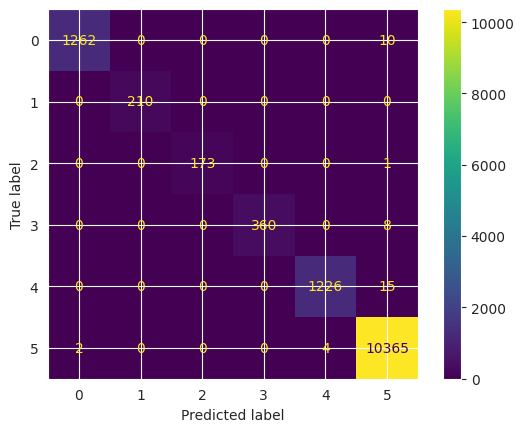

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

### Using Balanced Data

In [ ]:
clf2 = RandomForestClassifier(random_state=42)
clf2.fit(X_sampled_train, y_sampled_train)

y_pred = clf2.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train,y_pred, average = 'macro')
recall = recall_score(y_train,y_pred, average = 'macro')
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.3379875592729828
Recall: 0.6488762971709187
Accuracy: 0.5206805514813728


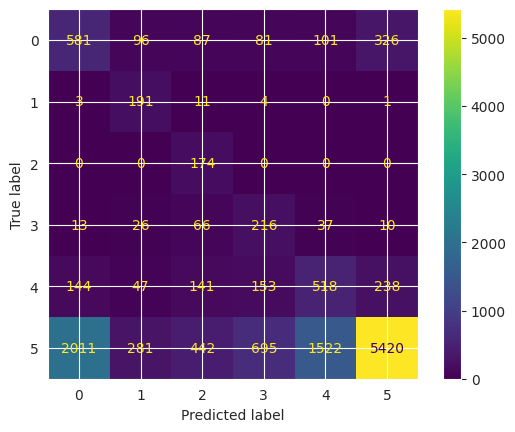

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_pred,values_format='.5g')

#### Using Unbalanced dataset and Countvectorized cum Random Forest Classifier is found to be more accurate

# Testing and Submission

### Using the model - Random Forest Classifier using Unbiased dataset and with 5 features: UserReputation, ReplyCount, ThumbsDownCount, BestScore and CountVectorized Recipe Reviews.

In [ ]:
X_test=vectorizer.transform(test['Recipe_Review'])
additional_features = test[['UserReputation','ReplyCount', 'ThumbsDownCount', 'BestScore']]
X_test_with_features = np.hstack((X_test.toarray(), additional_features.values))
y_pred = clf.predict(X_test_with_features)

In [ ]:
submission = pd.DataFrame(columns = ["ID","Rating"])
submission["ID"] = [i for i in range(1,4547)]
submission["Rating"] = [i for i in y_pred]
submission.to_csv("submission.csv",index=False)